# Overall Analysis of the Data and Preparation
## Assesing Quality + Fixing if neccessary 

In [1]:
# imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# retrieve data, set index to 0
df = pd.read_excel('../data/raw/psp_raw_data.xlsx', index_col=0)

In [3]:
## initial cleanup
# lower column names
df.rename(columns=str.lower, inplace=True)
# reset index 
df = df.reset_index(drop=True)

In [4]:
# visual check
display(df.head(15))
display(df.tail())

,tmsp,country,amount,success,psp,3d_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners
5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master
6,2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master
7,2019-01-01 00:08:46,Germany,117,1,UK_Card,0,Master
8,2019-01-01 00:09:56,Switzerland,174,0,Simplecard,0,Visa
9,2019-01-01 00:10:49,Switzerland,174,0,Simplecard,0,Visa


,tmsp,country,amount,success,psp,3d_secured,card
50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master
50409,2019-02-28 23:48:19,Austria,91,1,Moneycard,0,Master


In [5]:
# check data types
df.dtypes

tmsp          datetime64[ns]
country               object
amount                 int64
success                int64
psp                   object
3d_secured             int64
card                  object
dtype: object

In [6]:
# convert booleans to categorical type (success and 3d_secured)
df['success'] = df['success'].astype('object')
df['3d_secured'] = df['3d_secured'].astype('object')
df.dtypes

tmsp          datetime64[ns]
country               object
amount                 int64
success               object
psp                   object
3d_secured            object
card                  object
dtype: object

In [7]:
# check null values
print(df.isnull().sum())

tmsp          0
country       0
amount        0
success       0
psp           0
3d_secured    0
card          0
dtype: int64


- data quality is high
    - correct values, no missing values, types correct
        - boolean had to be changed, that's db and pandas specific though
- no missing values
- the distinct values are as expected for all features
- there is a imbalance in the target variable (success) of approximately 4:1)
    - with a high number of unsuccessful transactions
- the psp correspond with the provided names 

In [8]:
# check distinct values and count
for col in df.select_dtypes(include=['object']).columns:
    print(df[col].value_counts())
    print('---------------------------')

country
Germany        30233
Switzerland    10338
Austria         9839
Name: count, dtype: int64
---------------------------
success
0    40182
1    10228
Name: count, dtype: int64
---------------------------
psp
UK_Card       26459
Simplecard    12446
Moneycard      8297
Goldcard       3208
Name: count, dtype: int64
---------------------------
3d_secured
0    38399
1    12011
Name: count, dtype: int64
---------------------------
card
Master    29002
Visa      11640
Diners     9768
Name: count, dtype: int64
---------------------------


In [9]:
# add ratios to get a first feeling of the distribution
for col in df.select_dtypes(include=['object']).columns:
    value_counts = df[col].value_counts()
    percentages = df[col].value_counts(normalize=True) * 100
    result = pd.DataFrame({'count': value_counts, 'percentage': percentages})
    print(result)
    print('---------------------------')

             count  percentage
country                       
Germany      30233   59.974211
Switzerland  10338   20.507836
Austria       9839   19.517953
---------------------------
         count  percentage
success                   
0        40182   79.710375
1        10228   20.289625
---------------------------
            count  percentage
psp                          
UK_Card     26459   52.487602
Simplecard  12446   24.689546
Moneycard    8297   16.459036
Goldcard     3208    6.363817
---------------------------
            count  percentage
3d_secured                   
0           38399   76.173378
1           12011   23.826622
---------------------------
        count  percentage
card                     
Master  29002   57.532236
Visa    11640   23.090657
Diners   9768   19.377108
---------------------------


In [10]:
# check key metrics for numerical (and timestamp)
df.describe().T

,count,mean,min,25%,50%,75%,max,std
tmsp,50410,2019-01-29 16:28:52.923269120,2019-01-01 00:01:11,2019-01-14 12:00:36.249999872,2019-01-30 15:20:07.500000,2019-02-13 01:09:50.500000,2019-02-28 23:48:19,NaN
amount,50410.0,202.395715,6.0,133.0,201.0,269.0,630.0,96.27473


- Full months of January and February
- not taking into account the mean and percentiles for the amount since the records aren't aggregated on purchases but transaction (attempts)
    - min 6, max 630 though 

## Analysis of Cards and PSP

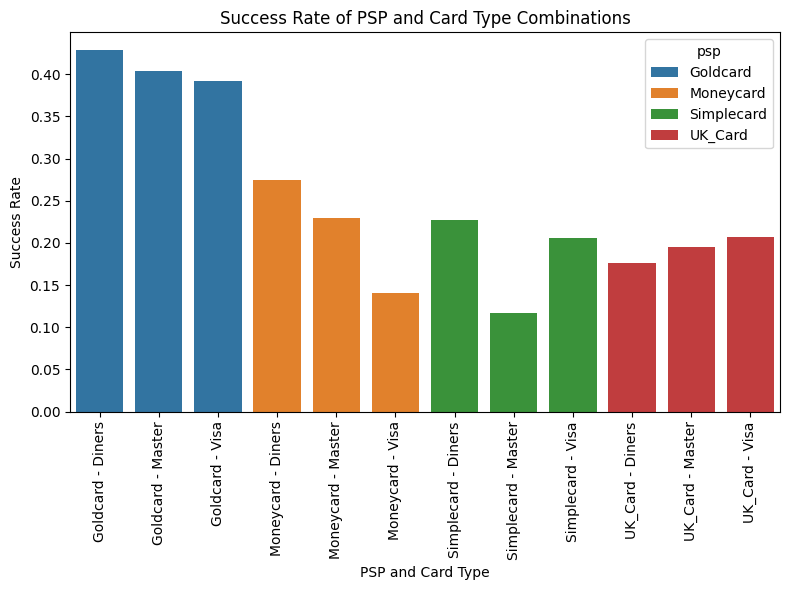

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it has been properly set up
df['tmsp'] = pd.to_datetime(df['tmsp'])

# Group by PSP and Card and calculate the count of transactions and the successful ones
grouped = df.groupby(['psp', 'card'])['success'].agg(['sum', 'count'])

# Calculate success rate for each PSP and card combination
grouped['success_rate'] = grouped['sum'] / grouped['count']

# Reset index for seaborn plotting
grouped_reset = grouped.reset_index()

# Create a new column for short_name (combining psp and card for labeling purposes)
grouped_reset['short_name'] = grouped_reset['psp'] + ' - ' + grouped_reset['card']

# Plot using Seaborn barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='short_name', y='success_rate', data=grouped_reset, hue='psp', dodge=False)

# Customize plot
ax.set_title('Success Rate of PSP and Card Type Combinations')
ax.set_xlabel('PSP and Card Type')
ax.set_ylabel('Success Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


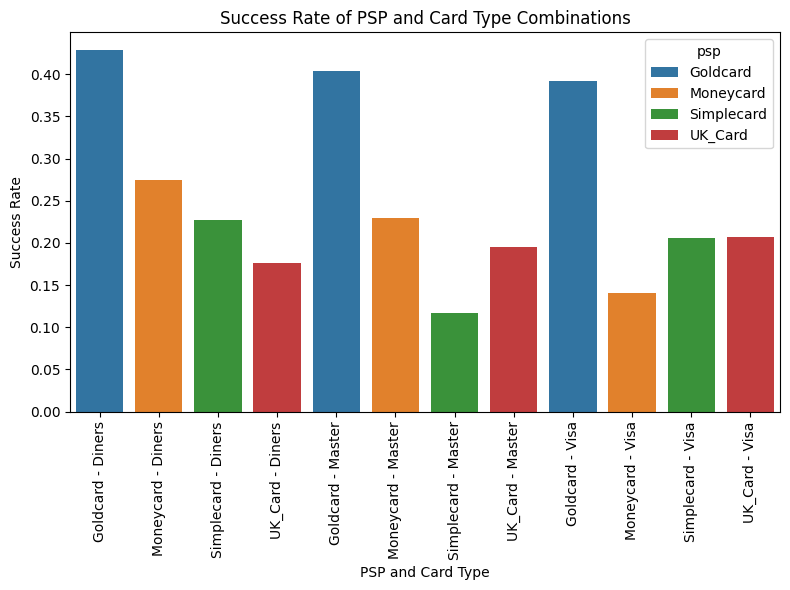

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and it has been properly set up
df['tmsp'] = pd.to_datetime(df['tmsp'])

# Group by PSP and Card and calculate the count of transactions and the successful ones
grouped = df.groupby(['psp', 'card'])['success'].agg(['sum', 'count'])

# Calculate success rate for each PSP and card combination
grouped['success_rate'] = grouped['sum'] / grouped['count']

# Reset index for seaborn plotting
grouped_reset = grouped.reset_index()

# Create a new column for short_name (combining psp and card for labeling purposes)
grouped_reset['short_name'] = grouped_reset['psp'] + ' - ' + grouped_reset['card']

# Reorder the data to sort by 'card' (so all card types are grouped together)
grouped_reset = grouped_reset.sort_values(by='card')

# Plot using Seaborn barplot, grouped by card
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='short_name', y='success_rate', data=grouped_reset, hue='psp', dodge=False)

# Customize plot
ax.set_title('Success Rate of PSP and Card Type Combinations')
ax.set_xlabel('PSP and Card Type')
ax.set_ylabel('Success Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [13]:
grouped_reset

,psp,card,sum,count,success_rate,short_name
0,Goldcard,Diners,287,670,0.428358,Goldcard - Diners
3,Moneycard,Diners,458,1667,0.274745,Moneycard - Diners
6,Simplecard,Diners,536,2356,0.227504,Simplecard - Diners
9,UK_Card,Diners,897,5075,0.176749,UK_Card - Diners
1,Goldcard,Master,712,1763,0.403857,Goldcard - Master
4,Moneycard,Master,1095,4765,0.229801,Moneycard - Master
7,Simplecard,Master,845,7245,0.116632,Simplecard - Master
10,UK_Card,Master,2971,15229,0.195088,UK_Card - Master
2,Goldcard,Visa,304,775,0.392258,Goldcard - Visa
5,Moneycard,Visa,262,1865,0.140483,Moneycard - Visa


sum  count success_rate
country     psp        card                            
Austria     Goldcard   Diners    64    129     0.496124
Switzerland Goldcard   Diners    67    144     0.465278
Austria     Goldcard   Master   142    328     0.432927
Switzerland Goldcard   Visa      74    178      0.41573
                       Master   150    364     0.412088
Germany     Goldcard   Visa     188    471     0.399151
                       Diners   156    397     0.392947
                       Master   420   1071     0.392157
Austria     Goldcard   Visa      42    126     0.333333
            Moneycard  Diners   105    338     0.310651
Switzerland Moneycard  Diners   105    379     0.277045
Germany     Moneycard  Diners   248    950     0.261053
Switzerland Moneycard  Master   235    935     0.251337
Austria     Simplecard Diners   108    450         0.24
            Moneycard  Master   216    957     0.225705
Germany     Simplecard Diners   316   1401     0.225553
            Moneycard  Master   644   2873     0.224156
Switzerland UK_Card    Visa     276   1239      0.22276
            Simplecard Diners   112    505     0.221782
Germany     Simplecard Visa     370   1726     0.214368
Austria     UK_Card    Visa     249   1192     0.208893
Germany     UK_Card    Visa     749   3724     0.201128
Switzerland Simplecard Visa     116    584      0.19863
Austria     UK_Card    Master   587   2986     0.196584
Germany     UK_Card    Master  1798   9180     0.195861
Switzerland UK_Card    Master   586   3063     0.191316
Austria     Simplecard Visa     101    535     0.188785
Germany     UK_Card    Diners   537   2999      0.17906
Austria     UK_Card    Diners   178   1010     0.176238
Switzerland UK_Card    Diners   182   1066     0.170732
Germany     Moneycard  Visa     164   1137     0.144239
Switzerland Moneycard  Visa      51    369     0.138211
Austria     Moneycard  Visa      47    359     0.130919
            Simplecard Master   174   1429     0.121763
Germany     Simplecard Master   498   4304     0.115706
Switzerland Simplecard Master   173   1512     0.114418

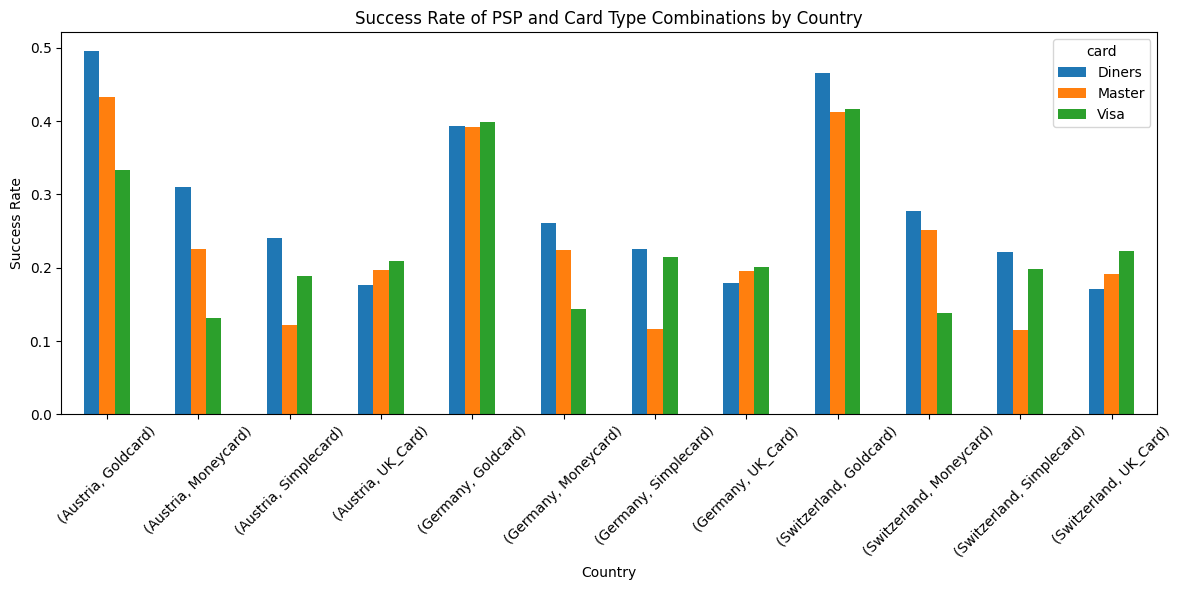

In [14]:
df['tmsp'] = pd.to_datetime(df['tmsp']) 

# Group by country, PSP, and card and calculate the count of transactions and the successful ones
grouped = df.groupby(['country', 'psp', 'card'])['success'].agg(['sum', 'count'])

# Calculate success rate for each combination
grouped['success_rate'] = grouped['sum'] / grouped['count']
grouped = grouped.sort_values(by='success_rate', ascending=False)

display(grouped)

# Plot the success rates for each country, PSP, and card combination
grouped['success_rate'].unstack().plot(kind='bar', figsize=(12, 6))

# Adding labels and title
plt.title('Success Rate of PSP and Card Type Combinations by Country')
plt.xlabel('Country')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## save data

In [15]:
# save corrected data 
df.to_csv('../data/intermediate/clean_data.csv', index=False)

### **1. Country Distribution:**
- **Germany** leads with the highest transaction count (**30,233**), comprising **59.97%** of the total transactions.
- **Switzerland** follows with **10,338** transactions (**20.51%**), while **Austria** has **9,839** transactions (**19.52%**).
- **Conclusion**: Germany is the dominant country in terms of transaction volume, accounting for nearly **60%** of the transactions. Switzerland and Austria contribute much smaller shares to the total transaction count.

---

### **2. Success Status (Success = 1, Failure = 0):**
- **Successful transactions (1)** account for **20.29%** of the total transactions, while **failed transactions (0)** make up **79.71%**.
- **Conclusion**: A significant majority of the transactions are unsuccessful, with failures making up over **79%**. This suggests there could be potential issues with the payment process or technical failures.

---

### **3. PSP (Payment Service Provider) Distribution:**
- **UK_Card** has the highest number of transactions (**26,459**), representing **52.49%** of the total transactions.
- **Simplecard** follows with **12,446** transactions (**24.69%**), while **Moneycard** has **8,297** transactions (**16.46%**).
- **Goldcard** has the lowest number of transactions (**3,208**), contributing **6.36%** of the total.
- **Conclusion**: **UK_Card** is the dominant PSP, processing more than half of the total transactions. The other PSPs are far less significant, with **Goldcard** accounting for a very small proportion of the total transactions.

---

### **4. 3D Secure Status (3d_secured = 1 means 3D secure was applied):**
- **Transactions without 3D secure (0)** represent **76.17%** of the total, while **transactions with 3D secure (1)** account for **23.83%**.
- **Conclusion**: The majority of transactions do not use 3D secure authentication. This may suggest that most transactions are processed without additional layers of security, which could be a concern for fraud prevention and security.

---

### **5. Card Type Distribution:**
- **Master** card is the most commonly used card type, with **29,002** transactions (**57.53%**).
- **Visa** follows with **11,640** transactions (**23.09%**), while **Diners** has the smallest count with **9,768** transactions (**19.38%**).
- **Conclusion**: **Master** card is the preferred card type by far, comprising more than **57%** of the transactions. **Visa** is the second most popular, and **Diners** card usage is relatively low.

---

### **Key Insights and Conclusions:**
1. **Germany dominates the transaction volume**, accounting for nearly **60%** of the transactions.
2. **The success rate is low**, with **79.7%** of transactions being unsuccessful. This could point to challenges with payment processing or potential fraud.
3. **UK_Card is the most popular PSP**, handling over **52%** of all transactions, while **Goldcard** processes a very small proportion of transactions.
4. A large portion of transactions does not use **3D secure**, which could pose a risk for fraud.
5. **Master cards** are the most common card type, with **57%** of transactions, while **Diners cards** are used the least.

These findings highlight areas for further investigation, particularly the high rate of failed transactions, the use of 3D secure, and the reliance on certain PSPs and card types.
